In [1]:
import typing as t
import operator as op
import subprocess as sp
import glob
import os
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from itertools import chain

import tqdm
import pandas as pd
from fn import F
from Bio import SearchIO

pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [2]:
samples = pd.read_csv('domains/samples_subsample.tsv', sep='\t')
ids = samples['id']

In [3]:
def parse_hmmer(path):
    return list(filter(bool, SearchIO.parse(path, 'hmmer3-text')))


scan_paths = [f'domains/hmmscan/{id_}.txt' for id_ in ids]
with ProcessPoolExecutor(20) as workers:
    scans = list(tqdm.tqdm(workers.map(parse_hmmer, scan_paths), total=len(scan_paths)))


100%|██████████| 5961/5961 [00:40<00:00, 146.74it/s]


In [4]:
def extract_query_annotations(query) -> pd.DataFrame:
    hmmscan_annotation_keys = [
        'query', 'model', 'description', 'bitscore', 'evalue'
    ]
    query_id = query.id
    hits = query.hits
    hit_ids = [hit.id for hit in hits]
    hit_descriptions = [hit.description for hit in hits]
    hit_scores = [hit.bitscore for hit in hits]
    hit_evalues = [hit.evalue for hit in hits]
    records = [
        [query_id, hit_id, hit_descr, hit_score, hit_eval]
        for hit_id, hit_descr, hit_score, hit_eval, in 
        zip(hit_ids, hit_descriptions, hit_scores, hit_evalues)
    ]
    return pd.DataFrame(records, columns=hmmscan_annotation_keys)


def extract_hmmscan_annotations(sample_id, sample_queries) -> t.Optional[pd.DataFrame]:
    query_annotations = (
        F(map, extract_query_annotations)
        >> list
    )(sample_queries)
    if not query_annotations:
        return None
    concatenated = (
        F(lambda dfs: pd.concat(dfs) if dfs else empty)
        >> (lambda df: df.reset_index(drop=True))
    )(query_annotations)
    return pd.concat([
        pd.Series(sample_id, index=concatenated.index, name='sample'),
        concatenated
    ], axis=1)


In [5]:
with tqdm.tqdm(scans) as scans_:
    scan_annotations = [
        extract_hmmscan_annotations(id_, scan)
        for id_, scan in zip(ids, scans_)
    ]


100%|█████████▉| 5955/5961 [01:48<00:00, 54.78it/s] 


In [6]:
scan_annotations_concat = (
    pd.concat([scan for scan in scan_annotations if scan is not None])
    .reset_index(drop=True)
    .sort_values(['sample'])
)
scan_annotations_concat.head()

,sample,query,model,description,bitscore,evalue
20179,GCF_000005825.2,BPOF4_RS19275,Cas14u,,177.9,1.300000e-53
20178,GCF_000005825.2,BPOF4_RS19275,V_U4,,202.2,4.600000e-61
20180,GCF_000005825.2,BPOF4_RS19275,V_U2,,147.2,2.800000e-44
20181,GCF_000005825.2,BPOF4_RS19275,Type_V_Cas14c,,146.7,3.100000e-44
20182,GCF_000005825.2,BPOF4_RS19275,Cas14c,,144.2,1.700000e-43


In [7]:
scan_annotations_concat.to_csv('domains/sample_domain_annotations.tsv', sep='\t', index=False)

In [8]:
model_counts = (
    scan_annotations_concat
    .groupby('sample')
    .apply(lambda grp: grp['model'].value_counts().to_frame().T)
    .reset_index(level=1, drop=True)
    .fillna(0)
)

In [9]:
model_counts.to_csv('domains/sample_domain_counts.tsv', sep='\t')

In [10]:
(
    model_counts
    .fillna(0)
    .groupby(list(scan_annotations_concat['model'].unique()))
    .apply(len)
    .reset_index(drop=True)
    .sort_values()
    .to_frame()
    .tail(10)
)

,0
1399,12
1691,13
535,15
547,15
13,17
9,18
491,23
589,41
144,77
87,190


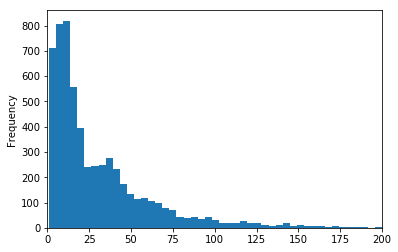

In [11]:
(
    model_counts
    .sum(axis=1)
    .plot.hist(bins=200, xlim=(0, 200))
)